In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [131]:
import pandas as pd
import tensorflow as tf
import numpy as np
from transformers import BertweetTokenizer, TFAutoModelForSequenceClassification
from transformers.optimization_tf import create_optimizer #To create the AdamW optimizer
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
bertweet_tokenizer = BertweetTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
bertweet_model = TFAutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=1)

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
%%time
train = pd.read_csv('../data/external/kaggle/train.csv')
tweets = list(train['text'].values)
labels = train['target'].values
tweets_train, tweets_val, y_train, y_val = train_test_split(tweets, labels, test_size=0.15)
tokenized_train = bertweet_tokenizer(tweets_train, truncation=True, padding=True)
tokenized_val = bertweet_tokenizer(tweets_val, truncation=True, padding=True)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train),y_train)).shuffle(buffer_size=1024).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_val),y_val)).batch(32)

CPU times: user 7.74 s, sys: 0 ns, total: 7.74 s
Wall time: 7.74 s


>We use AdamW (Loshchilov and Hutter, 2019) with a fixed learning rate of 1.e-5 and a batch size of 32 (Liu et al., 2019). We compute the task >performance after each training epoch on the validation set (here, we apply early stopping when no improvement is observed after 5 continuous >epochs), and select the best model checkpoint to compute the performance score on the test set. We repeat this fine-tuning process 5 times >with different random seeds, i.e. 5 runs for each task and each dataset. We report each final test result as an average over the test scores >from the 5 runs.

In [93]:
# weight_decay_scheduler = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)
# lr_scheduler = WarmUp(tf.optimizers.schedules.ExponentialDecay(1e-5, 100, 0.9))
# adam_w = AdamW(learning_rate=lr_scheduler, weight_decay=lambda : None)
# adam_w.weight_decay = lambda : weight_decay_scheduler(opt.iterations)
# adam = tf.keras.optimizers.Adam(learning_rate=5e-5)
num_epochs = 100
adam_w, lr_schedule = create_optimizer(init_lr=1e-6, 
                                       num_train_steps=num_epochs*train_dataset.cardinality(),
                                       num_warmup_steps=2500,
                                       weight_decay_rate=0.1)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
bertweet_model.compile(optimizer=adam_w, loss=loss, metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5)])

In [94]:
hist = bertweet_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=callbacks)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/100


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


203/203 [==============================] - ETA: 0s - loss: 0.6823 - f1_score: 0.0000e+00

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


203/203 [==============================] - 46s 179ms/step - loss: 0.6823 - f1_score: 0.0000e+00 - val_loss: 0.6882 - val_f1_score: 0.0000e+00
Epoch 2/100
203/203 [==============================] - 36s 177ms/step - loss: 0.6835 - f1_score: 0.0000e+00 - val_loss: 0.6881 - val_f1_score: 0.0000e+00
Epoch 3/100
203/203 [==============================] - 36s 176ms/step - loss: 0.6842 - f1_score: 0.0000e+00 - val_loss: 0.6881 - val_f1_score: 0.0000e+00
Epoch 4/100
203/203 [==============================] - 39s 190ms/step - loss: 0.6840 - f1_score: 0.0000e+00 - val_loss: 0.6881 - val_f1_score: 0.0000e+00
Epoch 5/100
203/203 [==============================] - 39s 190ms/step - loss: 0.6806 - f1_score: 0.0000e+00 - val_loss: 0.6880 - val_f1_score: 0.0000e+00
Epoch 6/100
203/203 [==============================] - 36s 179ms/step - loss: 0.6843 - f1_score: 0.0000e+00 - val_loss: 0.6879 - val_f1_score: 0.0000e+00
Epoch 7/100
203/203 [==============================] - 36s 180ms/step - loss: 0.6850 - f

In [133]:
%matplotlib inline

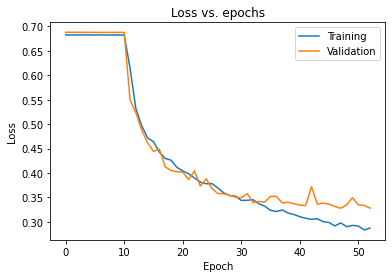

In [134]:
metrics = hist.history
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [228]:
%%time
bertweet_model.save_pretrained('../models/bertweet_finetuning/bertweet_kaggle')

CPU times: user 285 ms, sys: 371 ms, total: 656 ms
Wall time: 636 ms


In [ ]:
%%time
test = pd.read_csv('../data/external/kaggle/test.csv')
tweets = list(test['text'].values)
labels = train['target'].values
tweets_train, tweets_val, y_train, y_val = train_test_split(tweets, labels, test_size=0.15)
tokenized_train = bertweet_tokenizer(tweets_train, truncation=True, padding=True)
tokenized_val = bertweet_tokenizer(tweets_val, truncation=True, padding=True)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train),y_train)).shuffle(buffer_size=1024).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_val),y_val)).batch(32)

In [100]:
test = pd.read_csv('../data/external/kaggle/test.csv')
test = list(test['text'].values)
tokenized_test = bertweet_tokenizer(test, truncation=True, padding=True, return_tensors='tf')

In [119]:
logits = bertweet_model(tokenized_test['input_ids'], training=False).logits.numpy()

In [170]:
sentiment140 = pd.read_csv('../data/external/sentiment140/training.1600000.processed.noemoticon.zip', encoding='latin-1', header=None, names=['sentiment', 'id', 'date', 'no_query', 'user', 'tweet'])

In [172]:
sentiment_tweets = list(sentiment140['tweet'].values)

In [186]:
labels = sentiment140['sentiment']
labels = (labels == 4).astype(int)
labels

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: sentiment, Length: 1600000, dtype: int64

In [174]:
%%time
tokenized_sentiment_tweets = bertweet_tokenizer(sentiment_tweets, truncation=True, padding=True)

CPU times: user 6min 30s, sys: 0 ns, total: 6min 30s
Wall time: 6min 30s


In [201]:
%%time
tokenized_sentiment_tweet_tensors = bertweet_tokenizer(sentiment_tweets, truncation=True, padding=True, return_tensors='tf', return_token_type_ids=False)

CPU times: user 6min 14s, sys: 299 ms, total: 6min 14s
Wall time: 6min 14s


In [188]:
%%time
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_sentiment_tweets), labels)).shuffle(buffer_size=1024).batch(64)

In [202]:
tokenized_sentiment_tweet_tensors['input_ids']

<tf.Tensor: shape=(1600000, 128), dtype=int32, numpy=
array([[    0,     5,    10, ...,     1,     1,     1],
       [    0,    17,  2138, ...,     1,     1,     1],
       [    0,     5,     8, ...,     1,     1,     1],
       ...,
       [    0,   533,    14, ...,     1,     1,     1],
       [    0,   466,  4948, ...,     1,     1,     1],
       [    0,   225, 40993, ...,     1,     1,     1]], dtype=int32)>

In [205]:
tokenized_sentiment_tweet_tensors['attention_mask']

<tf.Tensor: shape=(1600000, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [223]:
%%time
bla = tf.data.Dataset.from_tensor_slices(tokenized_sentiment_tweet_tensors['input_ids']).batch(64)

CPU times: user 2.65 ms, sys: 233 µs, total: 2.88 ms
Wall time: 2.12 ms


In [224]:
bla.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=25000>

In [222]:
for thing in bla.take(1):
    print(thing)

tf.Tensor(
[[   0    5   10 ...    1    1    1]
 [   0   17 2138 ...    1    1    1]
 [   0    5    8 ...    1    1    1]
 ...
 [   0    5 3004 ...    1    1    1]
 [   0 2699  691 ...    1    1    1]
 [   0    8   45 ...    1    1    1]], shape=(12, 128), dtype=int32)


In [ ]:
bla = tf.data.Dataset.from_tensors

In [218]:
tf.data.Dataset.from_tensors(tokenized_sentiment_tweet_tensors['input_ids']).batch(12)

<BatchDataset shapes: (None, 1600000, 128), types: tf.int32>

In [216]:
for a in bla.take(1):
    print(a)

tf.Tensor(
[[[    0     5    10 ...     1     1     1]
  [    0    17  2138 ...     1     1     1]
  [    0     5     8 ...     1     1     1]
  ...
  [    0   533    14 ...     1     1     1]
  [    0   466  4948 ...     1     1     1]
  [    0   225 40993 ...     1     1     1]]], shape=(1, 1600000, 128), dtype=int32)


In [ ]:
training_dataset = tf.data.Dataset.zip(tokenized_sentiment_tweet_tensors)

In [204]:
tokenized_sentiment_tweet_tensors.keys()

dict_keys(['input_ids', 'attention_mask'])

In [198]:
tokenized_test.convert_to_tensors(tensor_type='tf')

{'input_ids': <tf.Tensor: shape=(3263, 55), dtype=int32, numpy=
array([[    0,   196,   911, ...,     1,     1,     1],
       [    0,  8305,    62, ...,     1,     1,     1],
       [    0,    99,    17, ...,     1,     1,     1],
       ...,
       [    0,  1906,  3875, ...,     1,     1,     1],
       [    0,  4793,   877, ...,     1,     1,     1],
       [    0, 49817,  1888, ...,     1,     1,     1]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3263, 55), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3263, 55), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32